In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!!sudo apt-get install swig3.0
!pip install jamspell
!pip install spacy-experimental
!pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.0/en_coreference_web_trf-3.4.0a0-py3-none-any.whl#egg=en_coreference_web_trf

In [ ]:
from pathlib import Path
import csv
import re
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import spacy
import spacy_experimental

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvf en.tar.gz
import jamspell
jsp = jamspell.TSpellCorrector()
assert jsp.LoadLangModel('en.bin')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--2025-03-09 02:36:11--  https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz [following]
--2025-03-09 02:36:11--  https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36611828 (35M) [application/octet-stream]
Saving to: ‘en.tar.gz.1’

en.tar.gz.1         100%[===================>]  34.92M  77.1MB/s    in 0.5s    

2025-03-09 02:36:12 (77.1 MB/s) - ‘en.tar.gz.1’ saved [36611828/36611828]

en.bin


In [ ]:
class Config:
    BASE_DIR = Path('/content/drive/MyDrive/College/machine_learning_2/submissions/1')
    DATA_DIR = BASE_DIR / 'datasets'
    MODEL_DIR = BASE_DIR / 'models'
    RESULT_DIR = BASE_DIR / 'results'

In [ ]:
train_data = fetch_20newsgroups(subset='train')
print(f"{len(train_data.filenames)} documents")
print(f"{len(train_data.target_names)} categories")
print()

11314 documents
20 categories



In [ ]:
pprint(list(train_data.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [ ]:
print(type(train_data))

<class 'sklearn.utils._bunch.Bunch'>


In [ ]:
train_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
train_data.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [ ]:
train_data.target[0]

7

In [ ]:
train_data.target_names[0]

'alt.atheism'

In [ ]:
#Saving the training data to google drive
csv_train_filename = Config.DATA_DIR / '20newsgroups_train.csv'

with open(csv_train_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(["content", "target", "category"])

    # Write the data
    for content, target, target_name in zip(train_data.data, train_data.target, train_data.target_names):
        writer.writerow([content, target, target_name])

print(f'Dataset saved as {csv_train_filename}')

Dataset saved as /content/drive/MyDrive/College/machine_learning_2/submissions/1/datasets/20newsgroups_train.csv


In [ ]:
test_data = fetch_20newsgroups(subset='test')
print(f"{len(test_data.filenames)} documents")
print(f"{len(test_data.target_names)} categories")
print()

7532 documents
20 categories



In [ ]:
#Saving the testing data to google drive
csv_test_filename = Config.DATA_DIR / '20newsgroups_test.csv'

with open(csv_test_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(["content", "target", "category"])

    # Write the data
    for content, target, target_name in zip(test_data.data, test_data.target, test_data.target_names):
        writer.writerow([content, target, target_name])

print(f'Dataset saved as {csv_test_filename}')

Dataset saved as /content/drive/MyDrive/College/machine_learning_2/submissions/1/datasets/20newsgroups_test.csv


In [ ]:
df_train = pd.DataFrame({
    'content': train_data.data,
    'target': train_data.target
})
df_train.head()

,content,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [ ]:
df_test = pd.DataFrame({
    'content': test_data.data,
    'target': test_data.target
})
df_test.head()

,content,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


In [ ]:
df_train.iloc[1]['content']

"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n"

In [ ]:
df_train.iloc[2]['content']

'From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swin

In [ ]:
target_names = train_data.target_names
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
# Create a mapping of target numbers to their corresponding categories
target_mapping = {i: category for i, category in enumerate(train_data.target_names)}
target_mapping

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

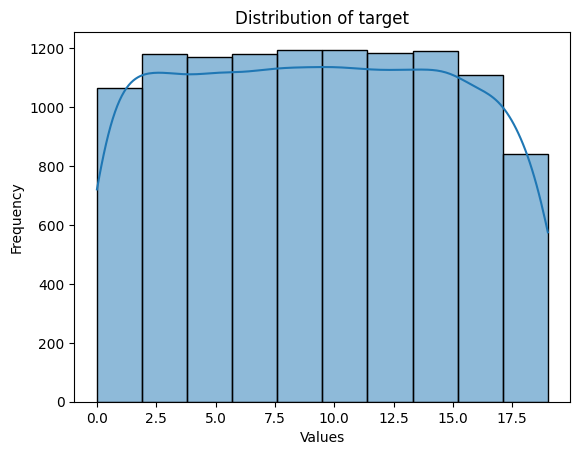

In [ ]:
# Plot the distribution of target in training set
sns.histplot(df_train['target'], kde=True, bins=10)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of target')

# Show the plot
plt.show()

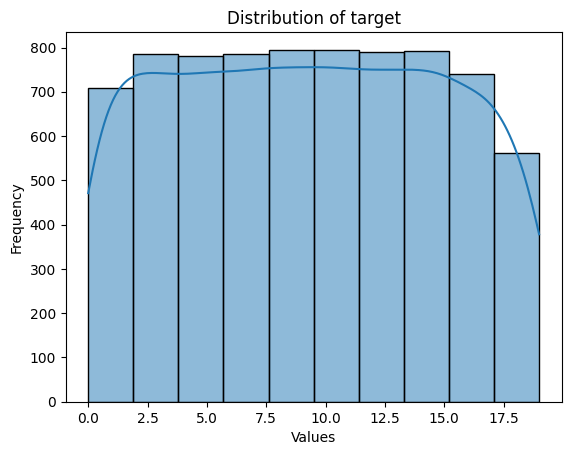

In [ ]:
# Plot the distribution of target in testing set
sns.histplot(df_test['target'], kde=True, bins=10)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of target')

# Show the plot
plt.show()

# Preprocessing

## Extracting Features
here I tried extracting some parts of the text that maybe by themselves can help predict the label pretty well

In [ ]:
# Function to extract the email from the text
def extract_email(text):
    emails = re.findall(r'\S+@\S+', text)
    if emails:
        email = emails[0]
        return email
    return None

In [ ]:
df_train['email'] = df_train['content'].apply(extract_email)
df_train.head()

,content,target,email
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,lerxst@wam.umd.edu
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,jgreen@amber
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu


In [ ]:
df_test['email'] = df_test['content'].apply(extract_email)
df_test.head()

,content,target,email
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,v064mb9k@ubvmsd.cc.buffalo.edu
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,<rick@ee.uwm.edu>
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,<mathew@mantis.co.uk>
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,bakken@cs.arizona.edu
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,livesey@solntze.wpd.sgi.com


this function extract the subject from the text if it exists by following these rules:

*  Extract everything after "Subject:".
*  Stop before the next word followed by : (like "Organization:").
*  Stop before any punctuation, newline, or space before a word followed by :.
*  Ensure the punctuation itself is not included in the result.
*  Handle cases where the subject is empty.

In [ ]:
# Function to extract subject from the text
def extract_subject(text):
    subject = re.search(r"^Subject:\s*([^\n:]*)(?=\s+\S+:|\n|$)", text, re.MULTILINE)
    if subject:
        subject = re.sub(r'[^a-zA-Z\s]', '', subject.group(1))
        return subject
    return None

In [ ]:
df_train['subject'] = df_train['content'].apply(extract_subject)
df_train.head()

,content,target,email,subject
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,lerxst@wam.umd.edu,WHAT car is this
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu,SI Clock Poll Final Call
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu,PB questions
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,jgreen@amber,
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu,


In [ ]:
df_test['subject'] = df_test['content'].apply(extract_subject)
df_test.head()

,content,target,email,subject
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,v064mb9k@ubvmsd.cc.buffalo.edu,Need info on Bonneville
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,<rick@ee.uwm.edu>,XFace
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,<mathew@mantis.co.uk>,
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,bakken@cs.arizona.edu,
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,livesey@solntze.wpd.sgi.com,


the instances where subject is null are still correct cause there really isn't any as you can see in the below example

In [ ]:
df_train.iloc[23]['content']

'From: csyphers@uafhp..uark.edu (Chris Syphers)\nSubject: Re: ?? DOS font size in windows??\nOrganization: Kansas State University\nLines: 20\nNNTP-Posting-Host: uafhp.uark.edu\n\nssa@unity.ncsu.edu (S. Alavi) writes:\n\n\n>\tI have an 8514/A card, and I am using windows in 1024x768 mode \n>\t(normal 8514/A font, not small).  In the 386 enhanced mode\n>\tthe DOS window font is too small for my 14" monitor. Is there a \n>\tway to spacify the font size for the DOS window? You\'ll have to \n>\texcuse me if there is a trivial answer, since I am fairly new to\n>\tMS Windows world.\n\n>\tThanks.\n\n>\t(Please include this message for reference)\n>\t======  S. Alavi    [ssa@unity.ncsu.edu]  (919)467-7909 (H)  ========\n>\t\t\t\t\t\t  (919)515-8063 (W)\nThe control box of the Window itself (upper left corner of the window, single\nclick, am I being too simplistic?) has a font option. The 8 X 12 is about the\nbiggest one I can use without the characters turning funky. \n\nHpoe this helps.\n'

In [ ]:
df_train['subject'].iloc[23]

''

In [ ]:
df_train['subject'].isnull().sum()

15

## Spell Checking
Fixing spelling mistakes using Jamspell

In [ ]:
jsp.FixFragment("I am the begt spell cherken")

'I am the best spell checker'

In [ ]:
df_train.iloc[20]['content']

'From: keith@cco.caltech.edu (Keith Allan Schneider)\nSubject: Re: <<Pompous ass\nOrganization: California Institute of Technology, Pasadena\nLines: 16\nNNTP-Posting-Host: punisher.caltech.edu\n\nlivesey@solntze.wpd.sgi.com (Jon Livesey) writes:\n\n[...]\n>>The "`little\' things" above were in reference to Germany, clearly.  People\n>>said that there were similar things in Germany, but no one could name any.\n>That\'s not true.  I gave you two examples.  One was the rather\n>pevasive anti-semitism in German Christianity well before Hitler\n>arrived.  The other was the system of social ranks that were used\n>in Imperail Germany and Austria to distinguish Jews from the rest \n>of the population.\n\nThese don\'t seem like "little things" to me.  At least, they are orders\nworse than the motto.  Do you think that the motto is a "little thing"\nthat will lead to worse things?\n\nkeith\n'

In [ ]:
jsp.FixFragment(df_train.iloc[2]['content'])

'From: willis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearance "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to maclean, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing

As we can see in the example, briefly was spelled incorrectly before in the text and now it is spelled correctly. now we can apply this to our entire dataset.

In [ ]:
df_train["content_cleaned"] = df_train["content"].apply(lambda txt: jsp.FixFragment(txt))
df_train.head()

,content,target,email,subject,content_cleaned
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,lerxst@wam.umd.edu,WHAT car is this,From: least@wam.umd.edu (where's my thing)\nSu...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu,SI Clock Poll Final Call,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu,PB questions,From: willis@ec.ecn.purdue.edu (Thomas E Willi...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,jgreen@amber,,From: green@amber (Joe Green)\nSubject: Re: We...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu,,From: jim@head-cfa.harvard.edu (Jonathan McDow...


In [ ]:
df_train['content_cleaned'].iloc[2]

'From: willis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearance "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to maclean, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing

In [ ]:
df_train['content'].iloc[2]

'From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swin

In [ ]:
df_test["content_cleaned"] = df_test["content"].apply(lambda txt: jsp.FixFragment(txt))
df_test.head()

,content,target,email,subject,content_cleaned
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,v064mb9k@ubvmsd.cc.buffalo.edu,Need info on Bonneville,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,<rick@ee.uwm.edu>,XFace,From: Rick Miller <rick@ee.uw.edu>\nSubject: S...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,<mathew@mantis.co.uk>,,From: mathew <mathew@mantis.co.uk>\nSubject: R...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,bakken@cs.arizona.edu,,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,livesey@solntze.wpd.sgi.com,,From: livesey@solvent.wpd.sgi.com (Jon Livesey...


In [ ]:
df_train['content'].iloc[4]

'From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA,  USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>"Clear caution & warning memory.  Verify no unexpected\n>>>errors. ...".  I am wondering what an "expected error" might\n>>>be.  Sorry if this is a really dumb question, but\n> \n> Parity errors in memory or previously known conditions that were waivered.\n>    "Yes that is an error, but we already knew about it"\n> I\'d be curious as to what the real meaning of the quote is.\n> \n> tom\n\n\nMy understanding is that the \'expected errors\' are basically\nknown bugs in the warning system software - things are checked\nthat don\'t have the right values in yet because they aren\'t\nset till after launch, and suchlike. Rather than

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\n', ' ', text)  # Remove new lines
    text = re.sub(r'[^a-zA-Z\s]', '', text) #Remove punctuation and anything that isn't English letters
    tokens = word_tokenize(text)  # Tokenize

    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # Assuming verbs
    return " ".join(lemmatized_tokens)

In [ ]:
preprocess_text(df_train.iloc[5]['content'])

'from foxvog douglas subject re reword the second amendment ideas organization vtt line in article c d tavares write in article foxvog douglas write in article c d tavares write in article john lawrence rutledge write the massive destructive power of many modern weapons make the cost of an accidental or crimial usage of these weapons to great the weapons of mass destruction need to be in the control of the government only individual access would result in the needless deaths of millions this make the right of the people to keep and bear many modern weapons nonexistant thank for state where youre come from needless to say i disagree on every count you believe that individuals should have the right to own weapons of mass destruction i find it hard to believe that you would support a neighbor right to keep nuclear weapons biological weapons and nerve gas on hisher property if we can not even agree on keep weapons of mass destruction out of the hand of individuals can there be any hope for

In [ ]:
df_train['content_cleaned'] = df_train['content_cleaned'].apply(preprocess_text)
df_train.head()

,content,target,email,subject,content_cleaned
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,lerxst@wam.umd.edu,WHAT car is this,from wheres my thing subject what car be this ...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu,SI Clock Poll Final Call,from guy kuo subject si clock poll final call ...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu,PB questions,from thomas e willis subject pb question organ...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,jgreen@amber,,from joe green subject re weitek p organizatio...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu,,from jonathan mcdowell subject re shuttle laun...


In [ ]:
df_test['content_cleaned'] = df_test['content_cleaned'].apply(preprocess_text)
df_test.head()

,content,target,email,subject,content_cleaned
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,v064mb9k@ubvmsd.cc.buffalo.edu,Need info on Bonneville,from neil b handler subject need info on bonne...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,<rick@ee.uwm.edu>,XFace,from rick miller subject sface organization ju...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,<mathew@mantis.co.uk>,,from mathew subject re strong weak atheism org...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,bakken@cs.arizona.edu,,from dave bakken subject re saudi clergy conde...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,livesey@solntze.wpd.sgi.com,,from jon livesey subject re after years can we...


# Seperating a validation set

splitting the sklearn pre split test set to test and validation sets

In [ ]:
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42)

print(f"df_test shape: {df_test.shape}")
print(f"df_valid shape: {df_valid.shape}")

df_test shape: (3766, 5)
df_valid shape: (3766, 5)


In [ ]:
# save dataframes to Google drive
df_train.to_csv(Config.DATA_DIR / '20newsgroup_train_preprocessed.csv')
df_valid.to_csv(Config.DATA_DIR / '20newsgroup_valid_preprocessed.csv')
df_test.to_csv(Config.DATA_DIR / '20newsgroup_test_preprocessed.csv')